In [1]:
from scGeneFit.functions import *

%matplotlib inline
import numpy as np
np.random.seed(0) 

In [2]:
from sklearn.neighbors import NearestCentroid
clf=NearestCentroid()

def performance(X_train, y_train, X_test, y_test, clf):
    clf.fit(X_train, y_train)
    return clf.score(X_test, y_test)

# ML

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
import time


from sklearn.impute import SimpleImputer
tcga = pd.read_csv('../../../data/My_own_project/TCGA_ready_monod2_intersectedSortedMerged_std_filtered_cpg5_std0.1_sorted_Allmatrix',sep='\t')
onevsall_NUM_MARKERS = 3
Replicate_Threshold =  150
Exclude_Targets = ['Kidney_TCGA-KIRP_Primary_Tumor','Kidney_TCGA-KIRC_Solid_Tissue_Normal','Bronchus_and_lung_TCGA-LUSC_Primary_Tumor']
print(tcga.shape)
tcga.head()

(2744, 10593)


,feature,Corpus_uteri_TCGA-UCEC_Primary_Tumor_8597f800-a2b5-43ce-b3f3-daa8c7048e13.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_cd70ed89-aad8-4e29-a71f-290a823471cf.methylation_array.sesame.level3betas.txt_WGBS,"Uterus,_NOS_TCGA-SARC_Primary_Tumor_c719a19b-5420-45f8-a023-9a2cc7fa94fe.methylation_array.sesame.level3betas.txt_WGBS",Palate_TCGA-HNSC_Primary_Tumor_aedf9a79-221f-4195-a962-db92372d097b.methylation_array.sesame.level3betas.txt_WGBS,Skin_TCGA-SKCM_Metastatic_a13db7a8-f424-4ef3-8359-5071991079e4.methylation_array.sesame.level3betas.txt_WGBS,Kidney_TCGA-KIRC_Solid_Tissue_Normal_0f48d8af-223f-4c00-9b13-540614d35bbc.methylation_array.sesame.level3betas.txt_WGBS,"Bones,_joints_and_articular_cartilage_of_other_and_unspecified_sites_TARGET-OS_Primary_Tumor_409b8601-71e2-4729-ab56-88ca4e1005a0.methylation_array.sesame.level3betas.txt_WGBS",Breast_TCGA-BRCA_Primary_Tumor_f089abf9-4cbc-407c-9207-439410f6d0a2.methylation_array.sesame.level3betas.txt_WGBS,Bladder_TCGA-BLCA_Primary_Tumor_06a77641-690f-4839-8ba0-e20f3d6fcc63.methylation_array.sesame.level3betas.txt_WGBS,...,"Uterus,_NOS_TCGA-UCS_Primary_Tumor_81bbea05-274f-435f-b547-19d4b3c152a2.methylation_array.sesame.level3betas.txt_WGBS",Hematopoietic_and_reticuloendothelial_systems_TARGET-AML_Bone_Marrow_Normal_b54bc046-87d2-431b-82b4-ad8694521851.methylation_array.sesame.level3betas.txt_WGBS,Breast_TCGA-BRCA_Primary_Tumor_c8e84511-71ce-4938-a374-99980bf6d7ba.methylation_array.sesame.level3betas.txt_WGBS,Cervix_uteri_TCGA-CESC_Primary_Tumor_01d86436-a861-4e72-bd5a-0ac0df35e4c0.methylation_array.sesame.level3betas.txt_WGBS,Cervix_uteri_TCGA-CESC_Primary_Tumor_4f9b862c-40f7-49ee-a68a-64504793a165.methylation_array.sesame.level3betas.txt_WGBS,Prostate_gland_TCGA-PRAD_Primary_Tumor_73298c7a-eff4-419f-a6f0-db31e208bf86.methylation_array.sesame.level3betas.txt_WGBS,Liver_and_intrahepatic_bile_ducts_TCGA-LIHC_Primary_Tumor_b16838f8-aff7-46e0-b030-3e452de748ba.methylation_array.sesame.level3betas.txt_WGBS,Corpus_uteri_TCGA-UCEC_Primary_Tumor_fe4ba5ac-1b7c-4913-a5a7-ff52d7707228.methylation_array.sesame.level3betas.txt_WGBS,Other_and_unspecified_parts_of_tongue_TCGA-HNSC_Primary_Tumor_56917a7d-9506-4165-b3a0-4f6063a5b508.methylation_array.sesame.level3betas.txt_WGBS,Bronchus_and_lung_TCGA-LUAD_Primary_Tumor_97db6454-78f6-4fb5-a488-5726522a7a7e.methylation_array.sesame.level3betas.txt_WGBS
0,chr10:100186139-100186254,0.041399,0.038079,0.042326,0.046239,0.043101,0.033680,0.040959,0.045317,0.045673,...,0.055478,0.042686,0.041410,0.039225,0.043447,0.058949,0.042591,0.041167,0.036830,0.037224
1,chr10:100229578-100229629,0.022317,0.018440,0.020859,0.018548,0.017185,0.018486,0.017680,0.018442,0.021058,...,0.024121,0.026927,0.018745,0.020033,0.023509,0.025678,0.028646,0.020030,0.024021,0.021566
2,chr10:100267670-100267870,0.035731,0.029624,0.029011,0.030375,0.028980,0.025504,0.033089,0.035994,0.029622,...,0.037764,0.031092,0.032122,0.036240,0.027703,0.037718,0.031346,0.043094,0.029956,0.025594
3,chr10:100286668-100286790,0.028009,0.036294,0.036452,0.033784,0.032713,0.029189,0.035594,0.037943,0.037887,...,0.038742,0.044145,0.033512,0.035239,0.039662,0.036926,0.035213,0.031359,0.029846,0.032740
4,chr10:100987280-100987660,0.019472,0.022886,0.023690,0.022559,0.023197,0.019916,0.023040,0.024651,0.024324,...,0.026392,0.026318,0.023245,0.025501,0.028305,0.027543,0.022978,0.025109,0.020021,0.022781


In [4]:
#### IMPUTATION should be seperately done
def train_test(input_df, threshold, exclude_targets=None, handle_nan='mean'):
    # Transpose the DataFrame
    df_transposed = input_df.T
    # Remove the first row
    df_transposed = df_transposed.drop(df_transposed.index[0])
    
    # Handle NaN values according to the specified strategy
    if handle_nan == 'mean':
        imputer = SimpleImputer(strategy='mean')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'median':
        imputer = SimpleImputer(strategy='median')
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'constant':
        imputer = SimpleImputer(strategy='constant', fill_value=-1)
        df_transposed.iloc[:, :] = imputer.fit_transform(df_transposed)
    elif handle_nan == 'remove':
        df_transposed.dropna(inplace=True)
    
    # List of substrings to search for
    substrings = ['_Tumor', 'Metastatic', '_Normal', '_Cancer']
    
    # Function to create a target value based on the index, by cutting off everything after the specified substrings
    def create_target(index):
        for substring in substrings:
            pos = index.find(substring)
            if pos != -1:
                # Cut off everything after the substring, but include the substring itself
                return index[:pos + len(substring)]
        # If no substring is found, return the index as is
        return index
    
    # Apply the function to each index to create the Target column
    df_transposed['Target'] = [create_target(index) for index in df_transposed.index]
    
    # Encode the 'Target' column, starting with 1
    df_transposed['Target_encoded'] = pd.factorize(df_transposed['Target'])[0] + 1
    
    # Calculate the frequency of each value in the 'Target' column
    value_counts = df_transposed['Target'].value_counts()
    
    # Determine which values meet or exceed the threshold
    values_to_keep = value_counts[value_counts >= threshold].index
    
    # Filter the DataFrame to only include rows with 'Target' values meeting/exceeding the threshold
    df_filtered = df_transposed[df_transposed['Target'].isin(values_to_keep)]
    
    # If exclude_targets is provided, remove rows with 'Target' values in exclude_targets
    if exclude_targets is not None:
        df_filtered = df_filtered[~df_filtered['Target'].isin(exclude_targets)]
    
    # Print information about the target values that pass the threshold
    print("Target values that pass the threshold:", values_to_keep.tolist())
    print("Total number of unique target values that pass the threshold:", len(values_to_keep))
    
    # Print the number of unique targets after excluding specific targets (if any)
    unique_targets_after_exclusion = df_filtered['Target'].nunique()
    print("Number of unique targets after exclusion:", unique_targets_after_exclusion)


    print(df_filtered.shape)


    X_train, X_test, y_train, y_test = train_test_split(
            df_filtered.drop(columns=['Target']), # Features (all columns except 'Target')
            df_filtered['Target'],                # Target variable
            test_size=0.2,                        # Size of the testing set, e.g., 20%
            random_state=0,                      # Seed for random number generator for reproducibility
            stratify=df_filtered['Target']        # Stratify based on the 'Target' column
        )
    return X_train, X_test, y_train, y_test, unique_targets_after_exclusion


# first run train_test
def data_for_scgenefit (df_filtered, df_target):
    # Separate the DataFrame into features, Target_encoded, and Target
    features = df_filtered.drop(['Target_encoded'], axis=1).to_numpy()
    target_encoded = df_filtered['Target_encoded'].to_numpy()
    target = df_target.tolist()
    
    # Return the features as a NumPy array, Target_encoded as a NumPy array, and Target as a list
    return features, target_encoded, target




In [5]:
X_train, X_test, y_train, y_test, number_of_target = train_test( tcga, Replicate_Threshold, exclude_targets = Exclude_Targets)
NUM_MARKERS = number_of_target*onevsall_NUM_MARKERS 
print(tcga.shape)
print(X_train.shape)
print(X_test.shape)

Target values that pass the threshold: ['Breast_TCGA-BRCA_Primary_Tumor', 'Brain_TCGA-LGG_Primary_Tumor', 'Thyroid_gland_TCGA-THCA_Primary_Tumor', 'Prostate_gland_TCGA-PRAD_Primary_Tumor', 'Bronchus_and_lung_TCGA-LUAD_Primary_Tumor', 'Corpus_uteri_TCGA-UCEC_Primary_Tumor', 'Bladder_TCGA-BLCA_Primary_Tumor', 'Stomach_TCGA-STAD_Primary_Tumor', 'Liver_and_intrahepatic_bile_ducts_TCGA-LIHC_Primary_Tumor', 'Bronchus_and_lung_TCGA-LUSC_Primary_Tumor', 'Skin_TCGA-SKCM_Metastatic', 'Kidney_TCGA-KIRC_Primary_Tumor', 'Colon_TCGA-COAD_Primary_Tumor', 'Cervix_uteri_TCGA-CESC_Primary_Tumor', 'Kidney_TCGA-KIRP_Primary_Tumor', 'Hematopoietic_and_reticuloendothelial_systems_TCGA-LAML_Primary_Blood_Derived_Cancer', 'Pancreas_TCGA-PAAD_Primary_Tumor', 'Esophagus_TCGA-ESCA_Primary_Tumor', 'Kidney_TCGA-KIRC_Solid_Tissue_Normal', 'Testis_TCGA-TGCT_Primary_Tumor']
Total number of unique target values that pass the threshold: 20
Number of unique targets after exclusion: 17
(6436, 2746)
(2744, 10593)
(5148, 2

In [6]:
def run_scgenefit(numpy_data,numpy_data_target, num_markers = NUM_MARKERS):
    [data, labels, names] = data_for_scgenefit(numpy_data,numpy_data_target)

    N,d=data.shape
    
    method='centers'
    redundancy=0.25

    start_time = time.time() # Record the start time
    markers= get_markers(data, labels, num_markers, method=method, redundancy=redundancy)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")
    
    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers], labels, data[:,markers], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)

    #TSNE plot
    a=plot_marker_selection(data, markers, names)

    return markers

In [7]:
def run_oneVSall (numpy_data,numpy_data_target, num_markers = onevsall_NUM_MARKERS ):
    [data, labels, names] = data_for_scgenefit(numpy_data, numpy_data_target)

    N,d=data.shape

    start_time = time.time() # Record the start time
    #markers2=one_vs_all_selection(data,labels)
    markers2=one_vs_all_selection_per_class(data,labels,num_markers=num_markers)
    #print(type(markers2))
    #print(markers2)
    end_time = time.time() # Record the end time
    print(f"Execution time: {end_time - start_time} seconds")

    accuracy=performance(data, labels, data, labels, clf)
    accuracy_markers=performance(data[:,markers2], labels, data[:,markers2], labels, clf)
    
    print("Accuracy (whole data,", d, " markers): ", accuracy)
    print("Accuracy (selected", num_markers, "markers)", accuracy_markers)
    a=plot_marker_selection(data, markers2, names)
    return markers2

In [8]:
y_train_modified = y_train.str.split('_').str[0]


Solving a linear program with 2744 variables and 74 constraints
Time elapsed: 0.5246419906616211 seconds
Execution time: 0.5266678333282471 seconds
Accuracy (whole data, 2744  markers):  0.7816627816627817
Accuracy (selected 51 markers) 0.7799145299145299
Computing TSNE embedding
Elapsed time: 32.921343088150024 seconds


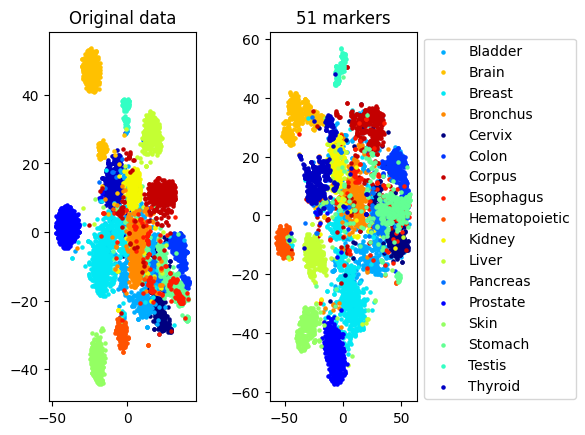

In [9]:
#scMarkers = run_scgenefit(X_train,y_train)
scMarkers = run_scgenefit(X_train,y_train_modified)

Execution time: 167.42587804794312 seconds
Accuracy (whole data, 2744  markers):  0.7816627816627817
Accuracy (selected 3 markers) 0.7595182595182595
Computing TSNE embedding
Elapsed time: 31.278029203414917 seconds


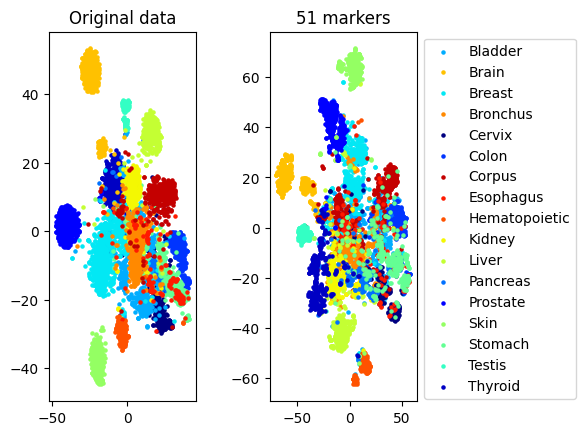

In [10]:
#one_vs_all_Markers = run_oneVSall(X_train,y_train)
one_vs_all_Markers = run_oneVSall(X_train,y_train_modified)

# ML

In [11]:
X_train_ready = X_train.drop(['Target_encoded'], axis = 1)
X_test_ready = X_test.drop(['Target_encoded'], axis = 1)
X_train_ready.head()
X_test_ready.head()

,0,1,2,3,4,5,6,7,8,9,...,2734,2735,2736,2737,2738,2739,2740,2741,2742,2743
Bronchus_and_lung_TCGA-LUAD_Primary_Tumor_9234df3f-125a-4f10-90dc-5af6217bf4f1.methylation_array.sesame.level3betas.txt_WGBS,0.046211,0.019127,0.033442,0.049064,0.064469,0.022689,0.041637,0.053667,0.028632,0.026557,...,0.034962,0.052331,0.087064,0.106736,0.049533,0.029472,0.064287,0.064511,0.066474,0.041349
Bronchus_and_lung_TCGA-LUAD_Primary_Tumor_f6b63d7b-6ec4-434b-af5d-47024a02ddd4.methylation_array.sesame.level3betas.txt_WGBS,0.040038,0.021764,0.029692,0.035272,0.026568,0.02133,0.034173,0.044792,0.022262,0.02402,...,0.02989,0.041707,0.040111,0.147923,0.050073,0.028626,0.055848,0.067882,0.070648,0.053307
Breast_TCGA-BRCA_Primary_Tumor_4e89d742-492c-43f0-a9bb-a88b0603685d.methylation_array.sesame.level3betas.txt_WGBS,0.040182,0.015748,0.023919,0.031675,0.019054,0.017525,0.030068,0.031605,0.015558,0.017155,...,0.024215,0.032355,0.045468,0.102006,0.050685,0.029658,0.050248,0.060988,0.075724,0.032527
Cervix_uteri_TCGA-CESC_Primary_Tumor_d97bf776-ac99-4159-aeae-4400028f7409.methylation_array.sesame.level3betas.txt_WGBS,0.040308,0.037927,0.032818,0.034334,0.029048,0.02605,0.039602,0.042805,0.02614,0.026169,...,0.047256,0.044089,0.060066,0.197809,0.055797,0.052893,0.051512,0.076464,0.079494,0.058984
Skin_TCGA-SKCM_Metastatic_4639f70b-62d0-4906-b607-bd3e5cba8595.methylation_array.sesame.level3betas.txt_WGBS,0.046132,0.02542,0.033788,0.044459,0.024032,0.02044,0.038194,0.04537,0.02253,0.024597,...,0.032384,0.040359,0.049779,0.078436,0.046646,0.032707,0.065245,0.070593,0.066474,0.047782


In [20]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def develop_random_forest_and_show_roc(X_train, y_train, X_test, y_test, feature_indices=None,title = 'Receiver Operating Characteristic to Multi-class'):
    # Select features based on indices if provided
    if feature_indices is not None:
        X_train = X_train.iloc[:, feature_indices]
        X_test = X_test.iloc[:, feature_indices]

    # Print the number of features used
    num_features = X_train.shape[1]
    print(f'Number of features used: {num_features}')

    # Determine the number of classes and unique labels
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    # Binarize the output for multiclass ROC
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Initialize and fit the RandomForest classifier
    clf = RandomForestClassifier()
    clf.fit(X_train, y_train)

    # Predict probabilities for each class
    y_score = clf.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    auc_scores = []
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores.append(roc_auc[i])

    # Calculate and print the average AUC
    avg_auc = np.mean(auc_scores)
    print(f'Average AUC: {avg_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'lightblue', 'lightgreen', 'gray', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0}.{1} (AUC = {2:0.2f})'.format(i + 1, classes[i].split('_')[0], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=14)
    plt.tight_layout()
    plt.show()

    return clf

# Example usage:
# Select features by index, e.g., using the first, third, and fifth features
# feature_indices = [0, 2, 4]
#clf = develop_random_forest_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,title = 'All Features')


Number of features used: 2744
Average AUC: 0.99


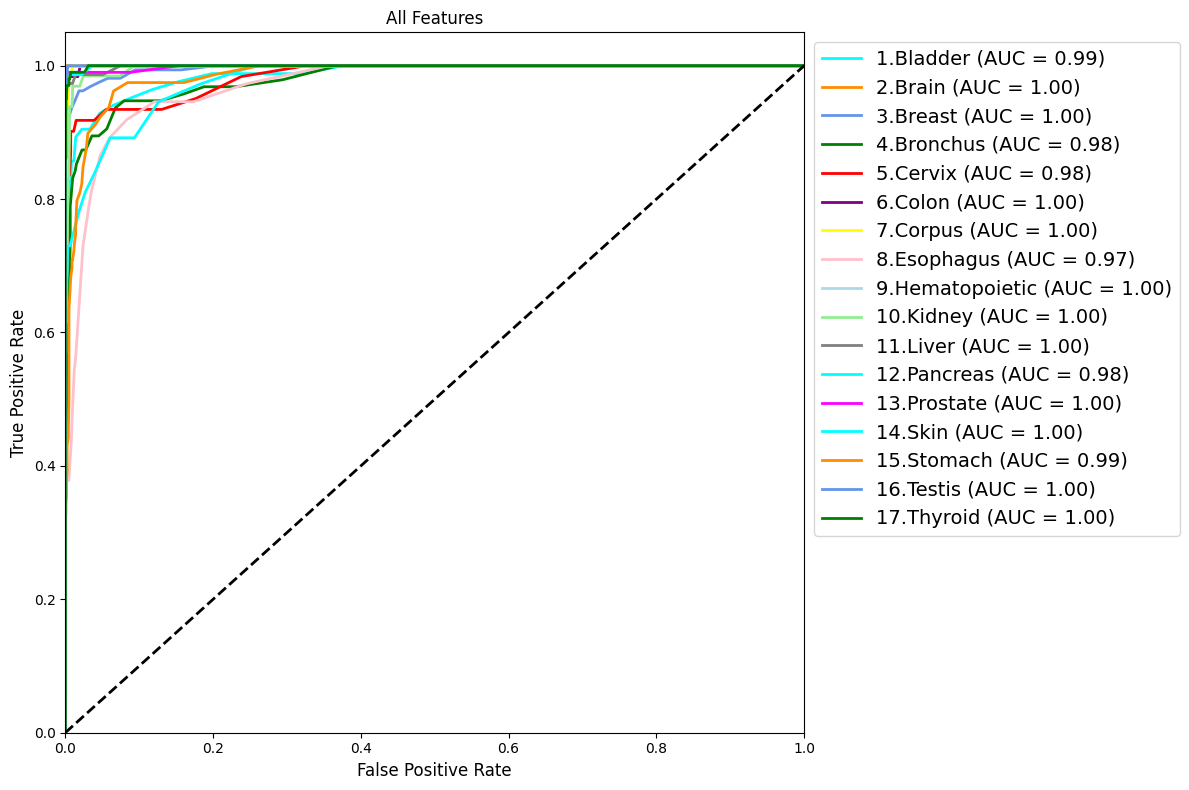

Number of features used: 51
Average AUC: 0.99


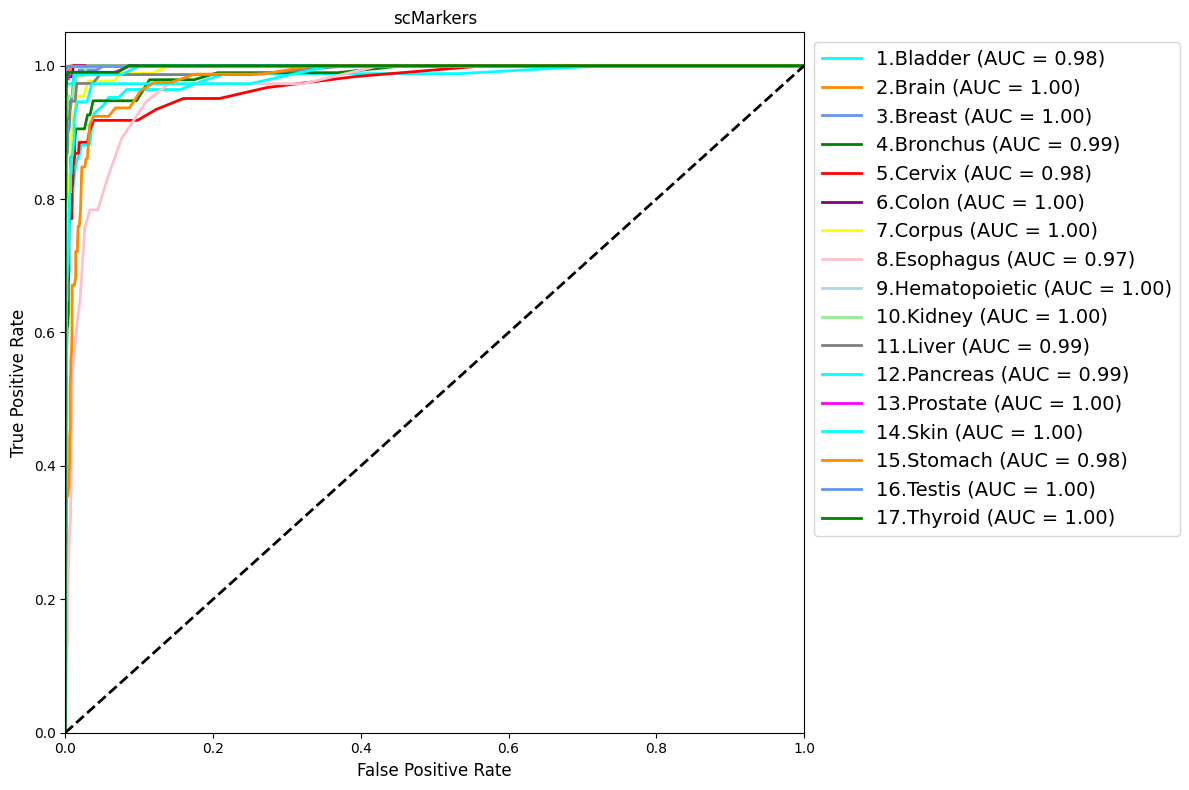

Number of features used: 51
Average AUC: 0.99


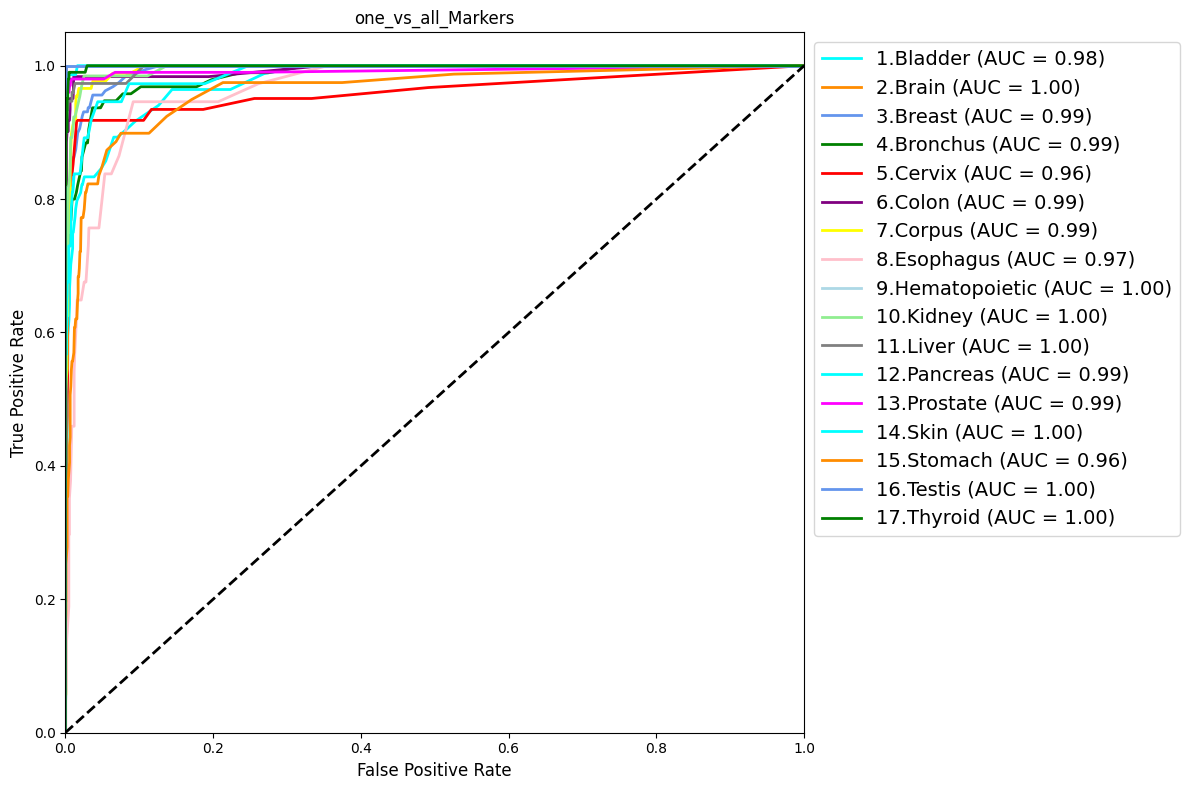

In [21]:
clf1 = develop_random_forest_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,title = 'All Features')
clf2 = develop_random_forest_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,feature_indices=scMarkers,title = 'scMarkers')
clf3 = develop_random_forest_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,feature_indices=one_vs_all_Markers,title = 'one_vs_all_Markers')

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle

def develop_knn_and_show_roc(X_train, y_train, X_test, y_test, feature_indices=None, n_neighbors=5, title='Receiver Operating Characteristic to Multi-class'):
    # Select features based on indices if provided
    if feature_indices is not None:
        X_train = X_train.iloc[:, feature_indices]
        X_test = X_test.iloc[:, feature_indices]

    # Print the number of features used
    num_features = X_train.shape[1]
    print(f'Number of features used: {num_features}')

    # Determine the number of classes and unique labels
    classes = np.unique(y_train)
    n_classes = len(classes)
    
    # Binarize the output for multiclass ROC
    y_train_bin = label_binarize(y_train, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)

    # Initialize and fit the KNN classifier
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)

    # Predict probabilities for each class
    # Note: KNN does not have predict_proba by default for all situations, so we use a workaround
    y_score = clf.predict_proba(X_test)

    # Compute ROC curve and ROC area for each class
    auc_scores = []
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        auc_scores.append(roc_auc[i])

    # Calculate and print the average AUC
    avg_auc = np.mean(auc_scores)
    print(f'Average AUC: {avg_auc:.2f}')

    # Plot ROC curve
    plt.figure(figsize=(12, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'green', 'red', 'purple', 'yellow', 'pink', 'lightblue', 'lightgreen', 'gray', 'cyan', 'magenta'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label='{0}.{1} (AUC = {2:0.2f})'.format(i + 1, classes[i].split('_')[0], roc_auc[i]))
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

    return clf


Number of features used: 2744
Average AUC: 0.96


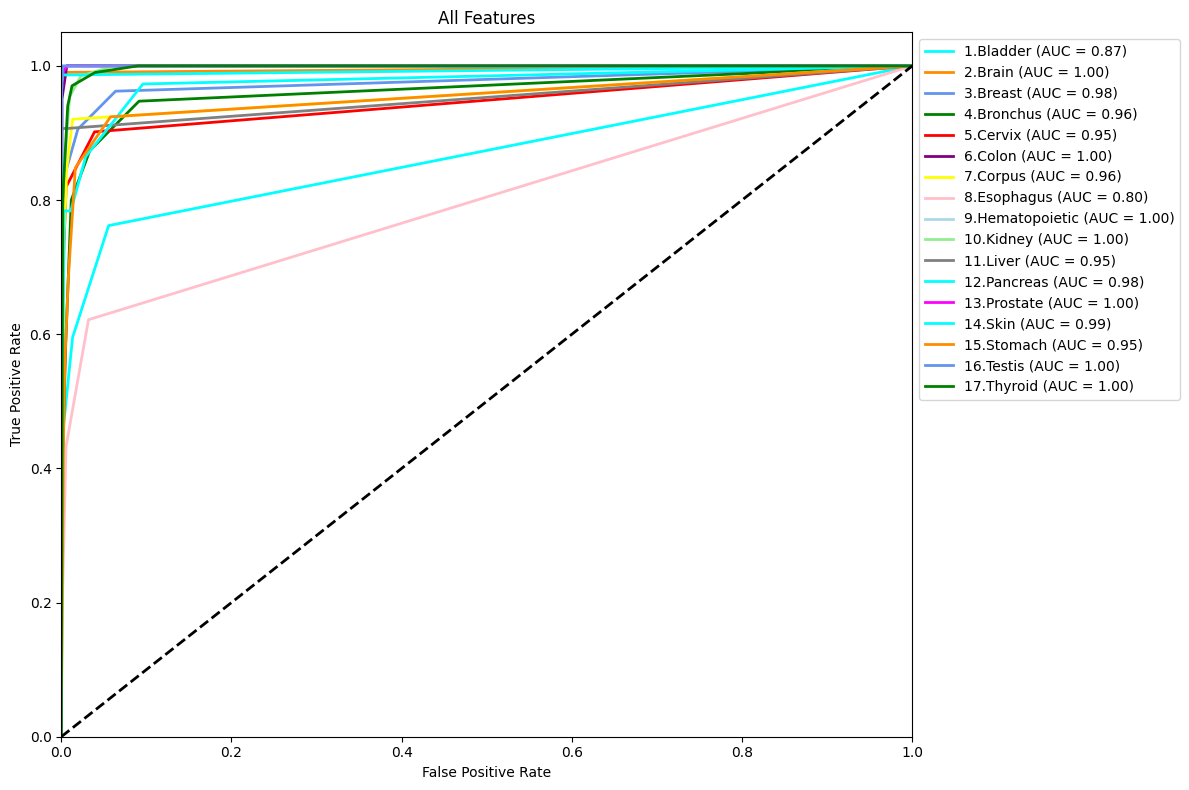

Number of features used: 51
Average AUC: 0.95


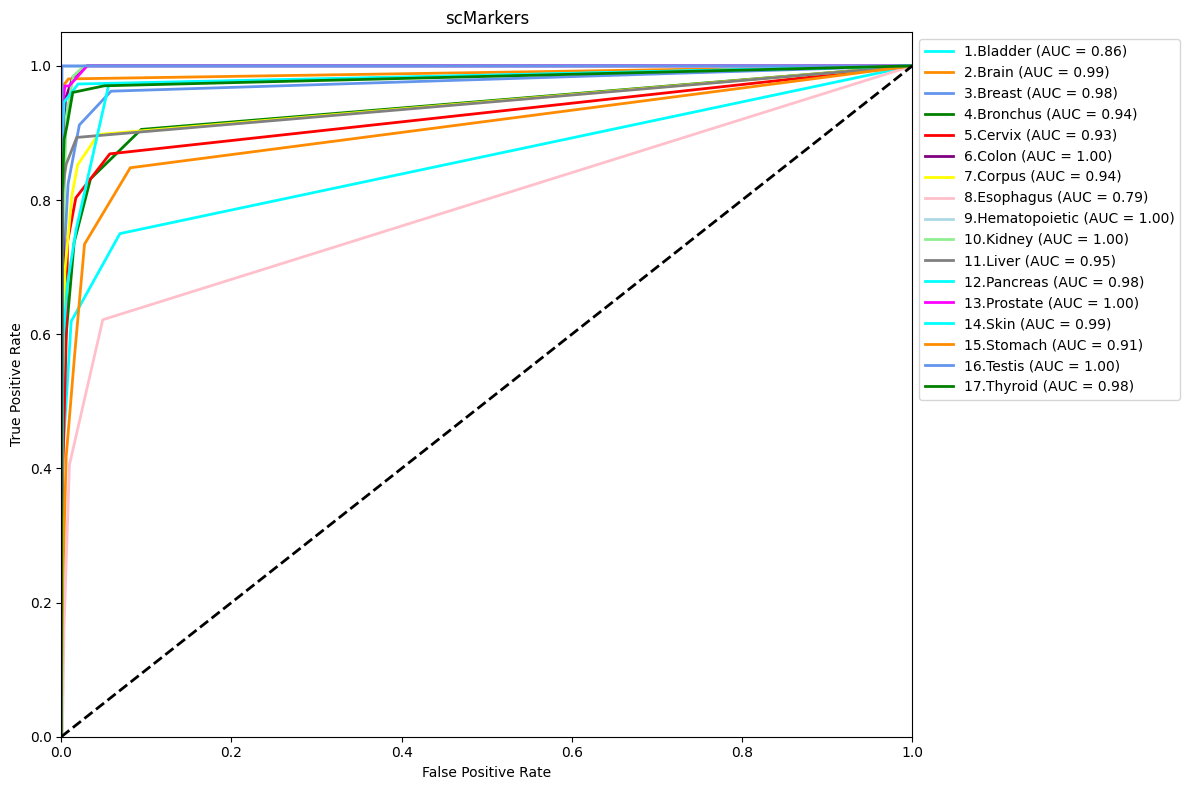

Number of features used: 51
Average AUC: 0.95


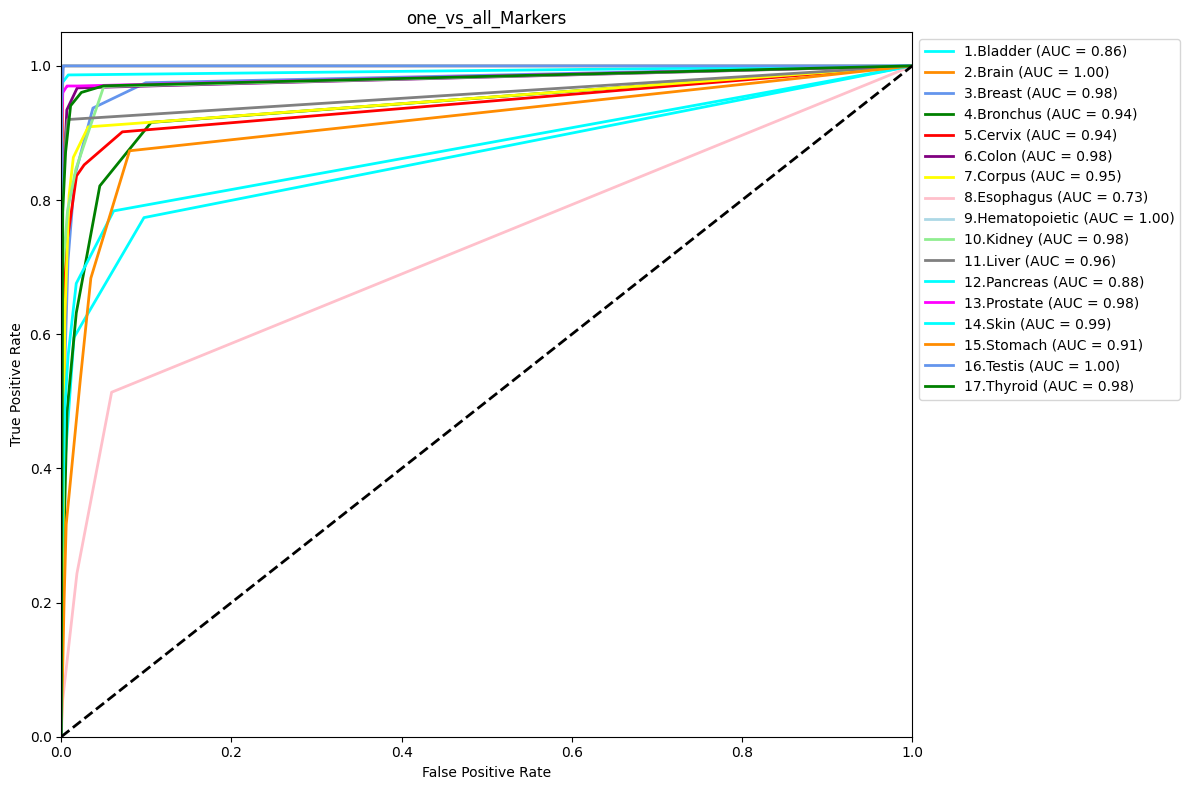

KNeighborsClassifier()

In [15]:
develop_knn_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,title = 'All Features')
develop_knn_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,feature_indices=scMarkers,title = 'scMarkers')
develop_knn_and_show_roc(X_train_ready, y_train, X_test_ready, y_test,feature_indices=one_vs_all_Markers,title = 'one_vs_all_Markers')

# ToDo:
* ROC using KNN like scgenefit paper if that looks better: See how they calculate the accuracy. If possible, convert to ROC on train and test for a figure for the DSS
* For one vs all, show the performance and runtime on all 450k as using MHB is my idea. So, even if MHB one vs all works well it is my contribution. 

# ISSUE:
* imputer seperation between train and test
* train test split in run_scgenefit and run_oneVSall